d:\Program Files\Python\Python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Feedforward ANN Trained on MNIST
Using device: cuda


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 4.60
Validation loss: 3.77
Validation accuracy: 13.28%
Training accuracy: 0.00%
----------------
Iteration: 50
Training loss: 0.28
Validation loss: 0.23
Validation accuracy: 91.41%
Training accuracy: 93.75%
----------------
Iteration: 100
Training loss: 0.17
Validation loss: 0.24
Validation accuracy: 91.41%
Training accuracy: 96.09%
----------------
Iteration: 150
Training loss: 0.20
Validation loss: 0.18
Validation accuracy: 94.53%
Training accuracy: 92.19%
----------------
Iteration: 200
Training loss: 0.19
Validation loss: 0.25
Validation accuracy: 94.53%
Training accuracy: 93.75%
----------------
Iteration: 250
Training loss: 0.28
Validation loss: 0.19
Validation accuracy: 93.75%
Training accuracy: 91.41%
----------------
Iteration: 300
Training loss: 0.29
Validation loss: 0.28
Validation accuracy: 91.41%
Training accuracy: 93.75%
----------------
Iteration: 350
Training loss: 0.25
Validation loss: 0.08
Validation accuracy: 97.66%
Training accuracy: 93.7

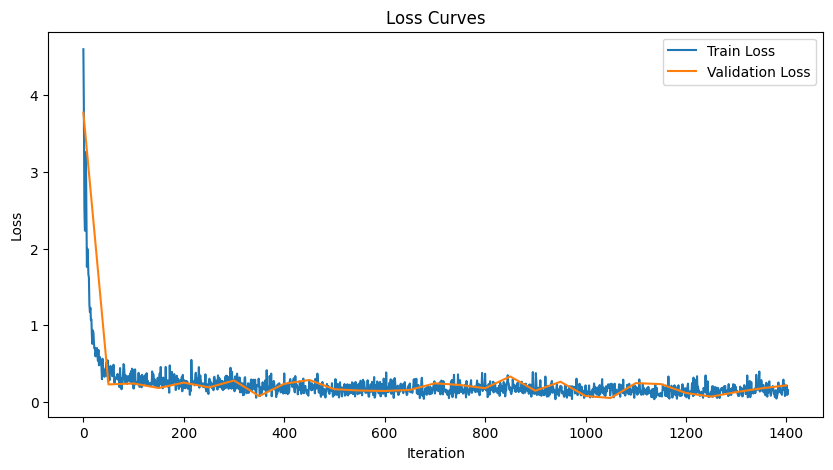

  0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 95.45%


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np

import random

from trainer import *

dtype=torch.float


print("Feedforward ANN Trained on MNIST")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


# Training Parameters
batch_size=128
data_path='./tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])


mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

train_sampler = torch.utils.data.RandomSampler(mnist_train, generator=gtrain,replacement=False)
test_sampler = torch.utils.data.RandomSampler(mnist_test, generator=gtest,replacement=False)

# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False,drop_last=True,pin_memory=True,sampler=train_sampler)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False,drop_last=True,pin_memory=True,sampler=test_sampler)

############ MNIST Model ################################

# layer parameters
num_inputs = 28*28
num_hidden1 = 40
num_hidden2 = 300
num_outputs = 100

lr=1e-2 #TODO learning rate does not directly translate from the SNN model due to the iteration steps for producing spikes
#weight_decay=1e-6


class Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.loss = nn.CrossEntropyLoss()
        self.accuracy_metric = lambda logits, targets: (torch.argmax(logits,dim=1) == targets).sum().item() / targets.size(0)

        self.linears = nn.ModuleList([
            nn.Linear(num_inputs, num_hidden1),
            nn.Linear(num_hidden1, num_hidden2),
            nn.Linear(num_hidden2, num_outputs)
        ])

        self.neurons = nn.ModuleList([
            nn.ReLU(),
            nn.ReLU(),
        ])
        
    def forward(self,x):
        x=x.view(x.size(0), -1)
        
        x = self.linears[0](x)
        x = self.neurons[0](x)
        x = self.linears[1](x)
        x = self.neurons[1](x)
        x = self.linears[2](x)
        return x


###############################
gen_reset()
net = trainer(Net,train_loader,test_loader,"./models/ANN_MNIST.pt",lr,3,None,50,1,False,device)
gen_reset()
test_stats(net,test_loader,None,device)

